# Start of Day 5 Week 1

In [ ]:
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torchvision
from PIL import Image
import einops
import numpy as np
from tqdm import tqdm

In [ ]:
fname = 'marmot.jpg'
img = Image.open(fname)
tensorize = torchvision.transforms.ToTensor()
marmot_img = tensorize(img)
marmot_np_img = np.array(img)

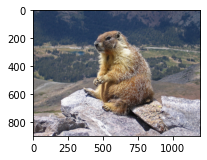

In [ ]:
def imshow(img, figsize=(4, 6)): 
    if img.shape[0] == 1:
        img = img[0]
        
    if img.shape[0] == 3:
        img = einops.rearrange(img, 'c h w -> h w c')
    
    plt.figure(figsize=figsize)
    plt.imshow(img)
    
imshow(np_img, (3, 4))

In [ ]:
model = torchvision.models.resnet34(pretrained=True)
model.eval();

In [ ]:
class ImageParam(nn.Module):
    
    def __init__(self, shape = (1, 3, 224, 224)):
        super().__init__()
        
        
        self.img = nn.Parameter(t.rand(shape))
        
    def forward(self, x):
        return t.clamp(x, 0, 1)
    


In [ ]:
image.img.shape

torch.Size([1, 3, 224, 224])

In [ ]:

image = ImageParam()
original_img = image.img.clone().detach()

optimizer = t.optim.Adam(image.parameters(), lr=0.05)

n_steps = 100

logit_values = []
for step in tqdm(range(n_steps)):
    optimizer.zero_grad()
    
    logit_50 = model(image.img)[0, 50]
    logit_values.append(logit_50.clone().detach())
    
    (-1 * logit_50).backward()
    optimizer.step()


100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


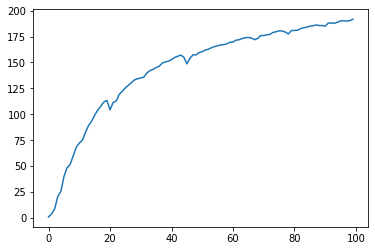

In [ ]:
plt.plot(logit_values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


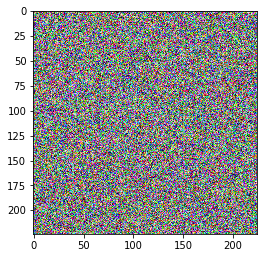

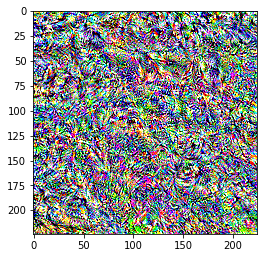

In [ ]:
imshow(original_img)
imshow(image.img.detach())

In [ ]:
params[0].shape

torch.Size([1000, 512])

In [ ]:
params[1].shape

torch.Size([1000])

### Image Parameterization 2: Sigmoid Instead of Clipping

In [ ]:
class ImageParam_2(nn.Module):
    
    def __init__(self, shape = (1, 3, 224, 224)):
        super().__init__()
        self.img = nn.Parameter(t.randn(shape))
        
    def forward(self):
        # print('!!')
        # self.img = self.img.sigmoid()
        return t.sigmoid(self.img)

In [ ]:
img_2 = ImageParam_2()

In [ ]:
x = t.randn((10, 10))
x_s = x.sigmoid()
x is x_s
x.equal(x_s)

x_s.equal(t.sigmoid(x))

True

In [ ]:
img_2.forward().min()

tensor(0.0094, grad_fn=<MinBackward1>)

In [ ]:
image = ImageParam_2()
original_img = image.img.clone().detach()
optimizer = t.optim.Adam(image.parameters(), lr=0.05)
n_steps = 150

logit_values = []
for step in tqdm(range(n_steps)):
    optimizer.zero_grad()
    
    logit_50 = model(image.forward())[0, 50]
    logit_values.append(logit_50.clone().detach())
    
    (-1 * logit_50).backward()
    optimizer.step()


100%|██████████| 150/150 [00:27<00:00,  5.53it/s]


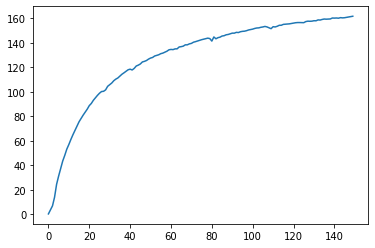

In [ ]:
plt.plot(logit_values)

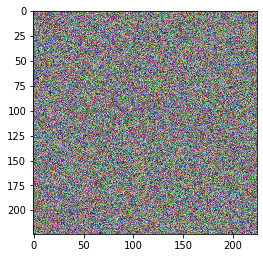

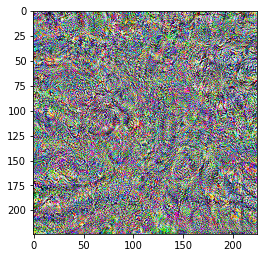

In [ ]:
imshow(original_img.sigmoid())
imshow(image.img.detach().sigmoid())

### Transformation robustness

In [ ]:
class ImageParam_3(nn.Module):
    
    def __init__(self, shape = (1, 3, 224, 224)):
        super().__init__()
        self.img = nn.Parameter(t.randn(shape))
        self.transforms = [
            torchvision.transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
            torchvision.transforms.RandomRotation(degrees=(0, 10)),
            torchvision.transforms.RandomCrop(size=(200, 200)),
            t.sigmoid
        ]
        
    def forward(self, img=None):
        if img is None: img = self.img
        for transform in self.transforms:
            img = transform(img)
        return img

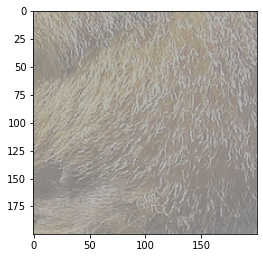

In [ ]:
image = ImageParam_3()
marmot_transformed = image.forward(marmot_img)
imshow(marmot_transformed)

In [ ]:
def train(image, n_steps=100, lr=0.05):
    
    optimizer = t.optim.Adam(image.parameters(), lr=lr)

    logit_values = []
    for step in tqdm(range(n_steps)):
        optimizer.zero_grad()

        logit_50 = model(image.forward())[0, 50]
        logit_values.append(logit_50.clone().detach())

        (-1 * logit_50).backward()
        optimizer.step()
        
    return logit_values

In [ ]:
image = ImageParam_3()
original_img = image.img.clone().detach()

logit_values = train(image, 500)

100%|██████████| 500/500 [01:17<00:00,  6.46it/s]


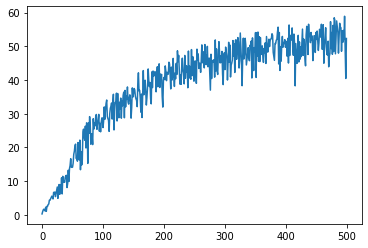

In [ ]:
plt.plot(logit_values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


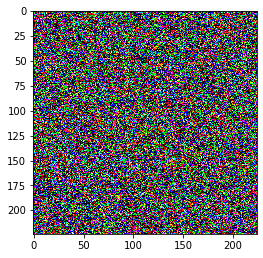

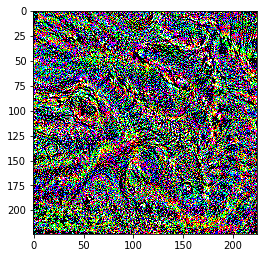

In [ ]:
imshow(original_img)
imshow(image.img.detach())

## Fourier basis

In [ ]:
class ImageParam_4(nn.Module):
    
    def __init__(self, shape = (1, 3, 224, 112, 2)):
        super().__init__()
        self.img = nn.Parameter(t.randn(shape))
        
    def forward(self, img=None):
        if img is None: img = self.img
            
        _, _, height, width, _ = img.shape
            
        return t.fft.irfft2(t.view_as_complex(img), s=(height, width*2), norm="ortho").sigmoid()
        

100%|██████████| 250/250 [00:57<00:00,  4.35it/s]


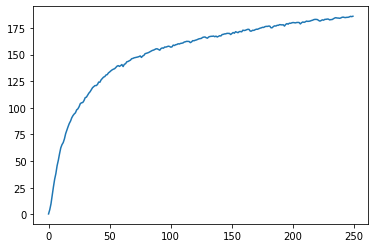

In [ ]:
image = ImageParam_4()
original_img = image.img.clone().detach()

logit_values = train(image, 250, lr=0.1)

plt.plot(logit_values)

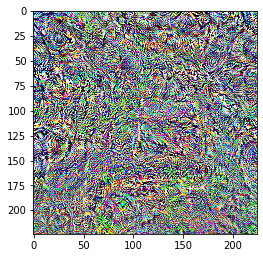

In [ ]:
imshow(image.forward().detach())

### Normalize by Frequency

In [ ]:
class ImageParam_5(nn.Module):
    
    def __init__(self, shape = (1, 3, 224, 112, 2)):
        super().__init__()
        self.img = nn.Parameter(t.randn(shape))
        _, _, height, width, _ = shape
        self.fx = fx = t.fft.fftfreq(height)**2
        self.fy = fy = t.fft.fftfreq(width)[:,None]**2
        freq_magnitude = (fx + fy).sqrt()
        freq_magnitude[0, 0] = 1 / height
        self.register_buffer('freq_magnitude', freq_magnitude)
        
    def forward(self, img=None):
        if img is None: img = self.img

        _, _, height, width, _ = img.shape
        
        img_as_complex = t.view_as_complex(img)
        
        # print(img_as_complex.size())
        # print(self.freq_magnitude.size())
        # self.get_buffer(name)
        irt_img = t.fft.irfft2(img_as_complex / self.freq_magnitude.T)
        irt_img += 0.5
        return irt_img.sigmoid()

100%|██████████| 2600/2600 [09:51<00:00,  4.39it/s]


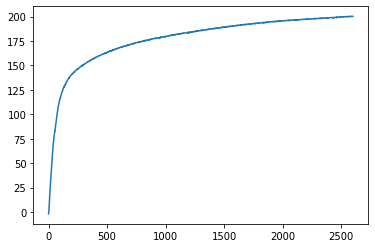

In [ ]:
image = ImageParam_5()
original_img = image.img.clone().detach()

logit_values = train(image, 2600, lr=0.35)
image.get_buffer('freq_magnitude')
plt.plot(logit_values)

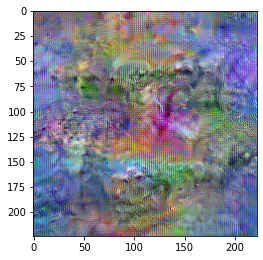

In [ ]:
imshow(image.forward().detach())

### Image parameterization 4: Channel decorrelation


In [ ]:
class ImageParam_6(nn.Module):
    
    def __init__(self, shape = (1, 3, 224, 224)):
        super().__init__()
        self.img = nn.Parameter(t.randn(shape))
        
        self.decorrelated_to_rgb = t.tensor([
            [ 0.56282854,  0.19482528,  0.0432945],
            [ 0.5844758,   0.,         -0.10823626],
            [ 0.5844758, -0.19482528,  0.06494176],
        ])
        
        
    def forward(self, img=None):
        if img is None: img = self.img
        
        # t.tensor._mul
        transformed = t.einsum('bchw,cd->bdhw', img, self.decorrelated_to_rgb)
        return (transformed).sigmoid()



100%|██████████| 500/500 [00:48<00:00, 10.23it/s]


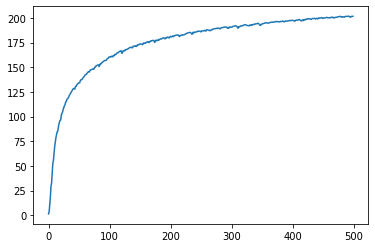

In [ ]:
image = ImageParam_6()

original_img = image.img.clone().detach()

logit_values = train(image, 500, lr=0.35)
plt.plot(logit_values)

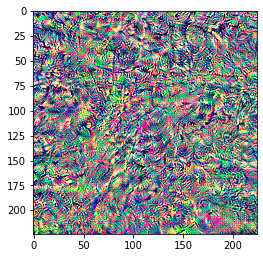

In [ ]:
imshow(image.forward().detach())

## Decorellation and Fourier transform

In [557]:
class ImageParam_7(nn.Module):
    
    def __init__(self, scale=1.0, transform=True, shape = (1, 3, 224, 112, 2)):
        super().__init__()
        
        # decorrelated_to_rgb = t.tensor([
        #     [ 0.56282854,  0.19482528,  0.0432945],
        #     [ 0.5844758,   0.,         -0.10823626],
        #     [ 0.5844758, -0.19482528,  0.06494176],
        # ])
        
        decorrelated_to_rgb = t.tensor([
            [0.26, 0.09, 0.02],
            [0.27, 0.00, -0.05],
            [0.27, -0.09, 0.03]
        ])
        
        self.register_buffer('decorrelated_to_rgb', decorrelated_to_rgb)
        
        self.scale = scale
        
        self.transform = transform
        self.transforms = [
            torchvision.transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
            torchvision.transforms.RandomRotation(degrees=(0, 10)),
            torchvision.transforms.RandomCrop(size=(200, 200))
        ]
        
        self.img = nn.Parameter(t.randn(shape))        
        _, _, height, width, _ = shape
        self.fx = fx = t.fft.fftfreq(height)**2
        self.fy = fy = t.fft.fftfreq(width)[:,None]**2
        freq_magnitude = (fx + fy).sqrt()
        freq_magnitude[0, 0] = 1 / height
        self.register_buffer('freq_magnitude', freq_magnitude)
        
    def forward(self, img=None):
        if img is None: img = self.img

        _, _, height, width, _ = img.shape
        img_as_complex = t.view_as_complex(img)
        irt_img = t.fft.irfft2(img_as_complex / self.freq_magnitude.T)
        
        irt_img = t.einsum('bchw,cd->bdhw', irt_img, self.decorrelated_to_rgb)
        
        if self.transform:
            for transform in self.transforms:
                irt_img = transform(irt_img)
        
        irt_img = irt_img * self.scale + 0.5
        return irt_img.sigmoid()
    


100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


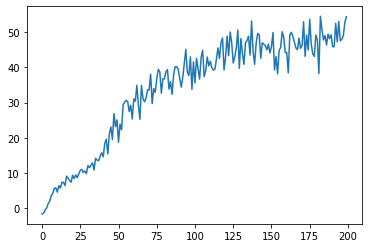

In [ ]:
image = ImageParam_7()

original_img = image.img.clone().detach()

logit_values = train(image, 200, lr=0.35)
plt.plot(logit_values)

In [ ]:


class ModelWithHook(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet34(pretrained=True)
        self.relus = [
            module for module in self.model.modules()
            if type(module) == nn.modules.activation.ReLU
        ]
        
        for i, relu in enumerate(self.relus):
            relu.register_forward_hook(self.hook(i))
        
        self.saved_values = [0]*len(self.relus)
        
    def forward(self, x):
        return self.model(x)
    
    def hook(self, index):
        
        def inner(module, inputs, outputs):
            self.saved_values[index] = outputs
            
        return inner
# storage aray
# def me(self, input, output): I Take output, 
# and i store the output in an array that is the size of [17][x]
 

#[module for module in list(model.modules()) if type(module) == nn.modules.activation.ReLU]

model = ModelWithHook()
image = ImageParam_7()
model(image.forward());

[val.shape for val in model.saved_values]

[torch.Size([1, 64, 100, 100]),
 torch.Size([1, 64, 50, 50]),
 torch.Size([1, 64, 50, 50]),
 torch.Size([1, 64, 50, 50]),
 torch.Size([1, 128, 25, 25]),
 torch.Size([1, 128, 25, 25]),
 torch.Size([1, 128, 25, 25]),
 torch.Size([1, 128, 25, 25]),
 torch.Size([1, 256, 13, 13]),
 torch.Size([1, 256, 13, 13]),
 torch.Size([1, 256, 13, 13]),
 torch.Size([1, 256, 13, 13]),
 torch.Size([1, 256, 13, 13]),
 torch.Size([1, 256, 13, 13]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 512, 7, 7])]

In [558]:

def inter_train(model, image, relu_idx, channel_idx, n_steps=100, lr=0.05):
    # optimizes an image to activate some intermediate-layer channel of post-ReLU activation
    #DEVICE = t.device("cuda:0" if t.cuda.is_available() else "cpu")
    DEVICE='cpu'
    image = image.to(DEVICE)
    model = model.to(DEVICE)

    optimizer = t.optim.Adam(image.parameters(), lr=lr)

    relu_values = model.saved_values
    loss_values = []
    for step in tqdm(range(n_steps)):
        optimizer.zero_grad()
        model(image.forward())
        relus = model.saved_values
        
        # 4th Relu, 50th Channel
        loss_pre_einsum = relus[relu_idx][0][channel_idx]
        loss = t.einsum('xy,xy->',loss_pre_einsum,loss_pre_einsum)
        loss_values.append(loss)
        (-1 * loss).backward()
        optimizer.step()
        
    return loss_values

model = ModelWithHook()
image = ImageParam_7(scale=10)
model(image.forward());

loss_values = inter_train(model, image, 4, 4, 100, 0.05)

100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


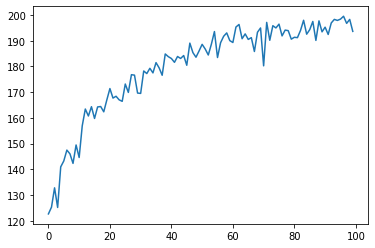

In [559]:
plt.plot([ loss_t.cpu().detach() for loss_t in loss_values])

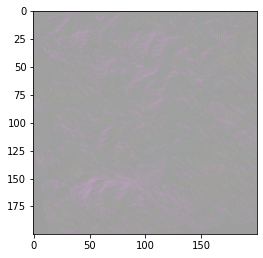

In [560]:
imshow(image.forward().cpu().detach())

In [545]:
class SaveOutput:
    def __init__(self):
        self.output = None
        
    def __call__(self, module, module_in, module_out):
        self.output = module_out
        
    def clear(self):
        self.output = None    

def optimize_img_inner(img, model, relu_id, channel_id, lr=0.05, n_epochs=200, apply_transforms=False):
    # optimizes an image to activate some intermediate-layer channel of post-ReLU activation
    DEVICE = "cpu"
    img = img.to(DEVICE)
    model = model.to(DEVICE)
    opt = torch.optim.Adam(img.parameters(), lr=lr)
    
    post_relu = []
    for i, m in enumerate(model.modules()):
        if isinstance(m, nn.ReLU):
            hook = SaveOutput()
            post_relu.append(hook)
            m.register_forward_hook(hook)
        
    for i in range(n_epochs):
        opt.zero_grad()
        image = img()
        if apply_transforms:
            image = TFORM(image)
            
        for hook in post_relu:
            hook.clear()
        model(image)
            
        loss = -(post_relu[relu_id].output[0, channel_id] **2).sum()
        loss.backward()
        opt.step()

    imshow(img().cpu().detach())

ImageParam_7()


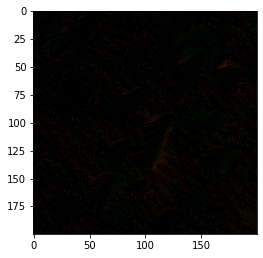

In [546]:
import torch as torch
print(img)
img = ImageParam_7()
optimize_img_inner(img, model, relu_id=4, channel_id=4, n_epochs=400)

In [ ]:
imshow(img.forward().